In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

In [2]:
import albumentations as A
from PIL import Image
from tqdm import tqdm
import dask.dataframe as dd

In [3]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# File paths
BASE_PATH = '/content/drive/MyDrive/207 Final Project/Models/transformed_data'
splits = ['train', 'val', 'test']

# Paths to processed sub-image files
TRAIN_PATH = '/content/drive/MyDrive/207 Final Project/Models/sub_images/train_data.npz'
VAL_PATH = '/content/drive/MyDrive/207 Final Project/Models/sub_images/val_data.npz'
TEST_PATH = '/content/drive/MyDrive/207 Final Project/Models/sub_images/test_data.npz'

In [5]:
# Training data
train_data = np.load(TRAIN_PATH)

X_train = train_data['images']
y_train = train_data['labels']

# Validation data
val_data = np.load(VAL_PATH)

X_val = val_data['images']
y_val = val_data['labels']

# Testing data
test_data = np.load(TEST_PATH)

X_test = test_data['images']
y_test = test_data['labels']


## EDA

In [6]:
# Shapes of each set
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (47700, 64, 64, 3)
y_train shape (47700,)
X_val shape (23900, 64, 64, 3)
y_val shape (23900,)
X_test shape (23900, 64, 64, 3)
y_test shape (23900,)


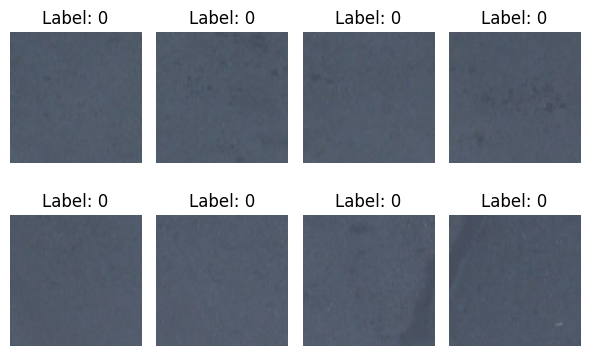

In [7]:
# Plot 8 random images from training
random_indices = np.random.choice(len(X_train), size=8, replace=False)

# Plot a few
plt.figure(figsize=(6,4))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data preprocessing

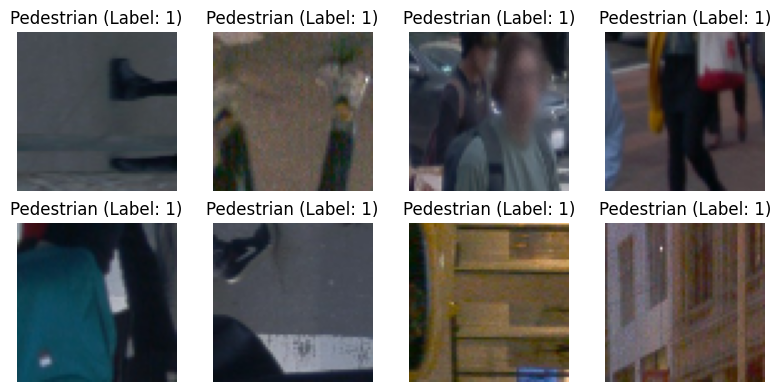

In [8]:
# Plot some images with pedestrians
# Get indices of pedestrian-labeled images
ped_indices = np.where(y_train == 1)[0]

# Sample randomly from positive examples
selected_indices = np.random.choice(ped_indices, size=8, replace=False)

# Plot
plt.figure(figsize=(8, 4))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Pedestrian (Label: 1)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (47700, 64, 64, 3)
y_train shape (47700,)
X_val shape (23900, 64, 64, 3)
y_val shape (23900,)
X_test shape (23900, 64, 64, 3)
y_test shape (23900,)


In [10]:
print("Train Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_train)}")
print(f"Positive (pedestrian) labels: {np.sum(y_train)}")
print(f"Negative labels: {np.sum(y_train == 0)}")

Train Set Class Breakdown
--------------------------
Total sub-images: 47700
Positive (pedestrian) labels: 3828
Negative labels: 43872


In [11]:
print("Val Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_val)}")
print(f"Positive (pedestrian) labels: {np.sum(y_val)}")
print(f"Negative labels: {np.sum(y_val == 0)}")

Val Set Class Breakdown
--------------------------
Total sub-images: 23900
Positive (pedestrian) labels: 1713
Negative labels: 22187


In [12]:
print("Test Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_test)}")
print(f"Positive (pedestrian) labels: {np.sum(y_test)}")
print(f"Negative labels: {np.sum(y_test == 0)}")

Test Set Class Breakdown
--------------------------
Total sub-images: 23900
Positive (pedestrian) labels: 1858
Negative labels: 22042


In [13]:
# Combine training + validation
X_pool = np.concatenate([train_data["images"], val_data["images"]])
y_pool = np.concatenate([train_data["labels"], val_data["labels"]])

# Identify indices
pos_indices = np.where(y_pool == 1)[0]
neg_indices = np.where(y_pool == 0)[0]

# Keep all positives
X_pos = X_pool[pos_indices]
y_pos = y_pool[pos_indices]

# Downsample negatives to match (1:2 ratio)
num_pos = len(X_pos)
num_neg = num_pos * 2
neg_sampled_indices = np.random.choice(neg_indices, size=num_neg, replace=False)
X_neg = X_pool[neg_sampled_indices]
y_neg = y_pool[neg_sampled_indices]

# Combine balanced data
X_bal = np.concatenate([X_pos, X_neg])
y_bal = np.concatenate([y_pos, y_neg])

# Shuffle the balanced dataset
indices = np.arange(len(X_bal))
np.random.shuffle(indices)
X_bal = X_bal[indices]
y_bal = y_bal[indices]

# Split into 60% train, 20% val, 20% test (dev test)
n_total = len(X_bal)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)

X_train_new = X_bal[:n_train]
y_train_new = y_bal[:n_train]

X_val_new = X_bal[n_train:n_train + n_val]
y_val_new = y_bal[n_train:n_train + n_val]

X_devtest_new = X_bal[n_train + n_val:]
y_devtest_new = y_bal[n_train + n_val:]

# Rescale images
X_train_new = X_train_new / 255.0
X_val_new = X_val_new / 255.0
X_devtest_new = X_devtest_new / 255.0

# Also load original full test set for final evaluation (no changes)
X_test_final = test_data["images"]
y_test_final = test_data["labels"]
X_test_final = X_test_final / 255.0

In [14]:
print("Train Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_train_new)}")
print(f"Positive (pedestrian) labels: {np.sum(y_train_new)}")
print(f"Negative labels: {np.sum(y_train_new == 0)}\n")

print("Val Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_val_new)}")
print(f"Positive (pedestrian) labels: {np.sum(y_val_new)}")
print(f"Negative labels: {np.sum(y_val_new == 0)}\n")

print("Dev Test Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_devtest_new)}")
print(f"Positive (pedestrian) labels: {np.sum(y_devtest_new)}")
print(f"Negative labels: {np.sum(y_devtest_new == 0)}")

Train Set Class Breakdown
--------------------------
Total sub-images: 9973
Positive (pedestrian) labels: 3307
Negative labels: 6666

Val Set Class Breakdown
--------------------------
Total sub-images: 3324
Positive (pedestrian) labels: 1112
Negative labels: 2212

Dev Test Set Class Breakdown
--------------------------
Total sub-images: 3326
Positive (pedestrian) labels: 1122
Negative labels: 2204


In [15]:
import gc

# Delete variables we don't need
del X_train, y_train, X_val, y_val
del X_pool, y_pool, pos_indices, neg_indices
del X_pos, y_pos, X_neg, y_neg
del X_bal, y_bal, indices, train_data, val_data, test_data
gc.collect()

30813

## Additional Data Preprocessing

In [16]:
# Get the number of features by multiplying the height, weight, and color channels.
num_features = X_train_new.shape[1] * X_train_new.shape[2] * X_train_new.shape[3]

# We need to flatten into a 1d array so the logistic regression model can ingest it
X_train_new_flat = X_train_new.reshape(X_train_new.shape[0], num_features)
X_devtest_new_flat = X_devtest_new.reshape(X_devtest_new.shape[0], num_features)
X_val_new_flat = X_val_new.reshape(X_val_new.shape[0], num_features)
X_test_final_flat = X_test_final.reshape(X_test_final.shape[0], num_features)

# Normalize pixel values so they range between 0 and 1
X_train_new_scaled = X_train_new_flat / 255.0
X_devtest_new_scaled = X_devtest_new_flat / 255.0
X_val_new_scaled = X_val_new_flat / 255.0
X_test_final_scaled = X_test_final_flat / 255.0

## sklearn Logistic Regression Model

In [17]:
# Build Logistic Regression Model Using SKlearn
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=10)
lr_model.fit(X_train_new_scaled, y_train_new)

# Check Validation Accuracy
accuracy_val = lr_model.score(X_val_new_scaled, y_val_new)
print(f"Validation Accuracy: {accuracy_val}")

Validation Accuracy: 0.6654632972322503


## Tensorflow Logistic Regression Model

In [18]:
# # Build Logistic Regression Model using TF
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
  )

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4272 - loss: 4.2264 - val_accuracy: 0.4856 - val_loss: 2.9462
Epoch 2/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4678 - loss: 2.8683 - val_accuracy: 0.4883 - val_loss: 2.5431
Epoch 3/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4723 - loss: 2.4623 - val_accuracy: 0.4925 - val_loss: 2.1523
Epoch 4/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4751 - loss: 2.0693 - val_accuracy: 0.5006 - val_loss: 1.7796
Epoch 5/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4845 - loss: 1.6960 - val_accuracy: 0.5193 - val_loss: 1.4346


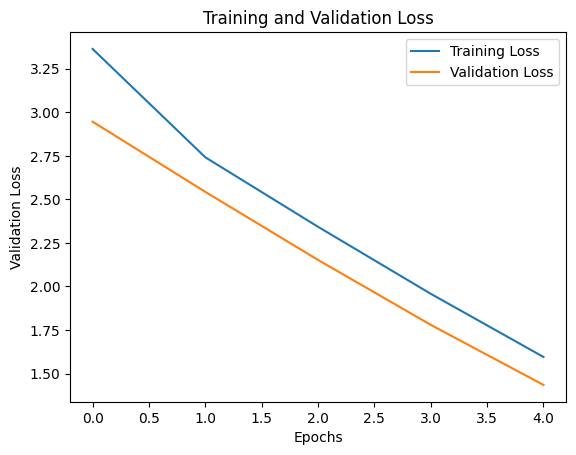

In [19]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
model_tf = build_model(num_features=num_features, learning_rate=0.8)

# 3. Fit the model
# YOUR CODE HERE
trained_model = model_tf.fit(
    X_train_new_scaled, y_train_new,
    epochs=5,
    batch_size=16,
    validation_data=(X_val_new_scaled, y_val_new)
)

# 4. Generate a plot with the loss values on the Y axis and epoch number on the X axis
plt.plot(trained_model.history['loss'], label='Training Loss')
plt.plot(trained_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluation

In [20]:
# Evaluate the TF Logistic Regression on DevTest
test_loss, test_accuracy = model_tf.evaluate(X_devtest_new_scaled, y_devtest_new)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 1.4612
Test Loss: 1.4545
Test Accuracy: 0.5174


In [21]:
# Get predictions for the TF Logistic Regression Model on DevTest
y_probs = model_tf.predict(X_devtest_new_scaled).flatten()
y_pred = (y_probs > 0.5).astype(int)

# Classification report for the TF Logistic Regression Model on DevTest
print("Classification Report:")
print(classification_report(y_devtest_new, y_pred))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67      2204
           1       0.13      0.07      0.09      1122

    accuracy                           0.52      3326
   macro avg       0.37      0.41      0.38      3326
weighted avg       0.45      0.52      0.48      3326



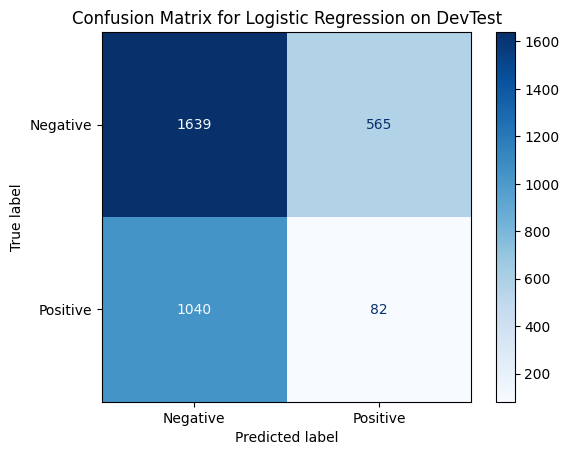

In [22]:
# Confusion matrix for TF Logistic Regression model on DevTest
cm = confusion_matrix(y_devtest_new, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Logistic Regression on DevTest')
plt.show()

In [23]:
# Further remove more unused arrays to save on RAM
del X_train_new_scaled, X_devtest_new_scaled, X_val_new_scaled
gc.collect()

4251

In [24]:
# Evaluate the TF Logistic Regression on Final Test
test_loss, test_accuracy = model_tf.evaluate(X_test_final_scaled, y_test_final)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for the TF Logistic Regression Model on Final Test
y_probs = model_tf.predict(X_test_final_scaled).flatten()
y_pred = (y_probs > 0.5).astype(int)

# Classification report for the TF Logistic Regression Model on Final Test
print("Classification Report:")
print(classification_report(y_test_final, y_pred))

747/747 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6708 - loss: 1.1074
Test Loss: 1.0309
Test Accuracy: 0.6846
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81     22042
           1       0.02      0.07      0.03      1858

    accuracy                           0.68     23900
   macro avg       0.46      0.40      0.42     23900
weighted avg       0.84      0.68      0.75     23900



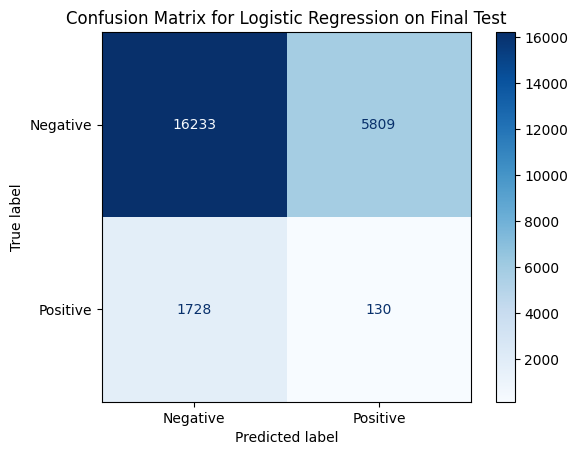

In [25]:
# Confusion matrix for TF Logistic Regression model on Final Test Set
cm = confusion_matrix(y_test_final, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Logistic Regression on Final Test')
plt.show()
